# Chapter 7. 텍스트 문서의 범주화 - (2) CNN Document Model

model/cnn_document_model.py에 구현된 DocumentModel CNN 문서 분류 모델의 주요 기능을 관련 코드와 함께 알아보자

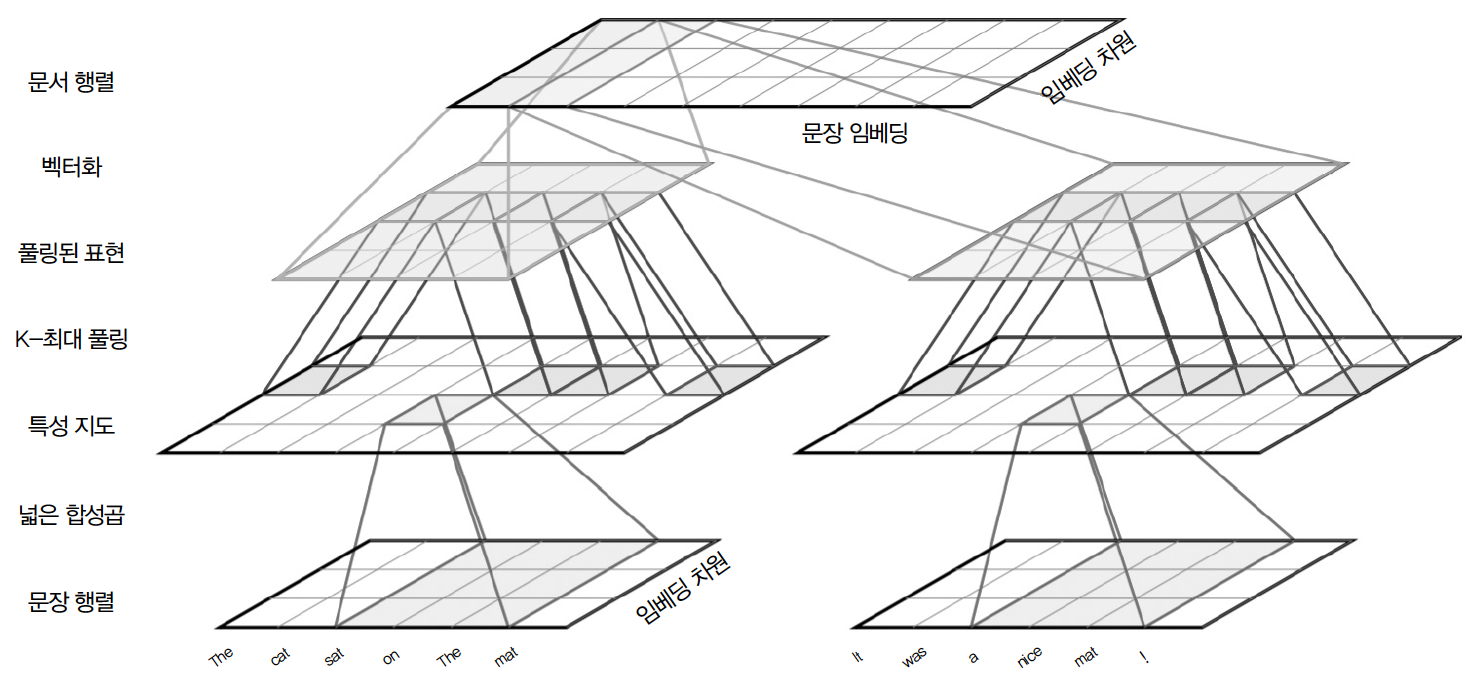

## CNN Document Model

- 문서의 계층적 분산 표현을 구현한 합성곱망(ConvNet)의 문서 모델이다
- 문장 수준과 문서 수준의 두 단계로 나뉘며, 둘 다 합성곱망(convNet)으로 구현된다
- 문장들을 단어 수중으로 임베딩 > 합성곱 > 풀링 하는 과정을 포함한다 

### 단어 인덱싱 처리
- empty값은 0, OOV(Out-of-Vocabulary) 단어는 1, 그 외 단어들은 고유한 인덱스값을 부여하는 방식으로 단어사전을 구축한다
- 단어 인덱싱 예시
```
dict_items([('the', 2), ('cat', 3), ('sat', 4), ('on', 5), ('mat', 6),
  ('.', 7), ('it', 8), ('was', 9), ('a', 10), ('nice', 11), ('!', 12),
  ('rat', 13), ('damaged', 14), ('found', 15), ('at', 16), ('places', 17)])
```

In [ ]:
# preprocessing/utils.py - Preprocess 클래스
class Preprocess:
    # ...(생략)...
    
    def _build_vocab(self):
        # 문서를 토큰화하여 각 단어 빈도 세기
        word_index ={}
        for doc in self.corpus:
            for sentence in sent_tokenize(doc):
                tokens = wordpunct_tokenize(sentence)
                tokens = [token.lower().strip()  for token in tokens]
                tokens = [token for token in tokens  if re.match('^[a-z]+$',token) is not None ]
                for token in tokens:
                    word_index[token] = word_index.get(token, 0)+1
                    
        filtered_word_index={}
        
        # 사용시 빈값은 0으로 (i = 0 for empty), 사전에 없는 단어는 1로 표기한다 (i = 1 for OOV)
        # 즉, vocabulary에 있는 단어는 모두 2 이상의 값을 인덱스로 할당받느다
        # 또한, 단어 빈도수가 MIN_WD_COUNT(5) 미만인 경우는 제외한다
        i = 2
        for word, count in word_index.items():
            if count >= Preprocess.MIN_WD_COUNT :
                filtered_word_index[word] = i
                i +=1
        print('Found %s unique tokens.' % len(filtered_word_index))
        return filtered_word_index

    # ...(생략)...

### 제로 패딩
- 각 인덱스값들의 시퀀스들에 대해 최대길이까지 남는 부분을 0으로 제로 패딩한다
- keras.preprocessing.sequence의 pad_sequences 모듈을 사용한다
- 제로 패딩 예시
```
[ 2 3 4 5 2 6 7 0 0 0 8 9 10 11 6 12 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 2 13 4 5 2 6 7 0 0 0 2 6 9 14 15 16 1 17 7 0 0 0 0 0 0 0 0 0 0 0]
```

In [ ]:
# preprocessing/utils.py - Preprocess 클래스

from keras.preprocessing.sequence import pad_sequences


class Preprocess:
    # ...(생략)...
    
    def _text2wordindex_seq(self, word_index, corpus):
        data = []
        doc_count = 0 
        for doc in corpus:
            doc2wordseq = []
            sent_num =0
            doc_count+=1
            if doc_count%1000 == 0 :
                percent_processed = doc_count*100/len(corpus)
                sys.stdout.write("\r%f%% documents processed." % percent_processed)
                sys.stdout.flush()
            for sentence in sent_tokenize(doc):
                
                words = wordpunct_tokenize(sentence)
                words = [token.lower().strip()  for token in words]
                word_id_seq = [word_index[word] for word in words  if word_index.get(word) is not None]
                #word_id_seq = tokenizer.texts_to_sequences([sentence])
                
                # padding : maxlen까지 남는 부분 제로패딩
                # truncating : maxlen 넘는 부분 제거
                # Preprocess.SENTENCE_LEN : 문장 최대 길이(단어수), 30
                padded_word_id_seq = pad_sequences([word_id_seq], maxlen=Preprocess.SENTENCE_LEN,
                                                   padding='post',
                                                   truncating='post')
                # ...(생략)...

### 단어 임베딩 (및 OOV 단어 처리)

- 인덱싱 처리된 각 단어들은 GloVe 모델을 통해 임베딩 초기화된다.
- 이 과정에서 OOV 단어들은 나머지 모든 벡터의 평균(np.mean)에 약간의 노이즈를 추가한 값으로 초기화한다. 
- pre-train된 GloVe 임베딩 벡터를 다운로드 받아 data 디렉토리에 압축 해제한다
    - 다운로드 : http://nlp.stanford.edu/data/glove.6B.zip
    - 저장경로 : data/glove.6B

In [ ]:
# dataloader/embeddings.py - GloVe 클래스
class GloVe:
    # ...(생략)...
    
    # 사전 학습된 GloVe 임베딩 모델 로드하기 (data/glove.6B/glove.6B.50d.txt)
    def _load(self):
        print('Reading {} dim GloVe vectors'.format(self.EMBEDDING_DIM))
        self.embeddings_index = {}
        with open(os.path.join(config.GLOVE_DIR, 'glove.6B.'+str(self.EMBEDDING_DIM)+'d.txt'),encoding="utf8") as fin:
            for line in fin:
                try:
                    values = line.split()
                    coefs = np.asarray(values[1:], dtype='float32')
                    word = values[0]
                    self.embeddings_index[word] = coefs  # GloVe 임베딩 데이터를 파이썬 딕셔너리 형태로 저장한다
                except:
                    print(line)

        print('Found %s word vectors.' % len(self.embeddings_index))

        
    # 위에서 로드한 임베딩 모델로 입력 문서를 임베딩 매트릭스로 만들기
    def _init_embedding_matrix(self, word_index_dict, oov_words_file='OOV-Words.txt'):
        self.embedding_matrix = np.zeros((len(word_index_dict)+2 , self.EMBEDDING_DIM))
        not_found_words=0
        missing_word_index = []
        
        # 각 단어들을 임베딩 벡터로 치환
        with open(oov_words_file, 'w') as f: 
            for word, i in word_index_dict.items():
                embedding_vector = self.embeddings_index.get(word)
                if embedding_vector is not None:
                    # words not found in embedding index will be all-zeros.
                    self.embedding_matrix[i] = embedding_vector
                else:
                    not_found_words+=1
                    f.write(word + ','+str(i)+'\n')
                    missing_word_index.append(i)

            # oov by average vector:
            self.embedding_matrix[1] = np.mean(self.embedding_matrix, axis=0)
            for indx in missing_word_index:
                self.embedding_matrix[indx] = np.random.rand(self.EMBEDDING_DIM)+ self.embedding_matrix[1]
        print("words not found in embeddings: {}".format(not_found_words))
    
    # ...(생략)...

### 임베딩 레이어

- 임베딩 행렬을 초기화 했으면 이제 다음과 같이 첫 번째 레이어인 임베딩 레이어를 만들 준비가 된 것이다.
- tf.keras.layers 의 Embedding 모듈로 임베딩 레이어를 생성하고 초기화된 임베딩 가중치를 입력한다
```
embedding_layer = Embedding(weights=[self.embedding_weights])
```

In [ ]:
# model/cnn_document_model.py - DocumentModel 클래스

from tensorflow.keras.layers import Embedding


class DocumentModel:
    # ...(생략)...

    def _build_model(self):
        max_seq_length = self.sentence_len*self.num_sentences

        # ...(생략)...

        # 초기화된 가중치를 입력한다면 그걸 사용하여 임베딩하는 레이어 생성
        if self.embedding_weights is not None:
            embedding_layer = Embedding(self.vocab_size,
                                        self.embedding_dim,                # 임베딩 깊이 50
                                        weights=[self.embedding_weights],  # 초기화된 가중치 입력
                                        input_length=max_seq_length,
                                        trainable=self.train_embedding,
                                        embeddings_regularizer = regularizers.l2(self.embedding_regularizer_l2),
                                        name='imdb_embedding')
        # ...(생략)...

### 컨볼루션 레이어

- 모든 문장에 동일한 1차원 합성곱 필터를 적용한다
- 람다(lambda) 레이어를 사용해서 입력을 문장 별로 나눈다
- 컨볼루션을 거치면 텐서의 모양은 다음과 같이 변한다
    - 컨볼루션 전 : SENTENCE_LEN x EMBEDDING_DIM
    - 컨볼루션 후 : (SENTENCE_LEN - kernel_size + 1) x filters

In [ ]:
# model/cnn_document_model.py - DocumentModel 클래스

from tensorflow.keras.layers import Conv1D


class DocumentModel:
    # ...(생략)...
    
    def _build_model(self):
        # ...(생략)...
        
        # 모든 문장에 대해 같은 컨볼루션 필터가 적용된다
        word_conv_model = Conv1D(filters=self.word_filters,           # 30
                                 kernel_size=self.word_kernel_size,   # 5
                                 padding="valid",
                                 activation=self.conv_activation, 
                                 trainable = self.learn_word_conv,
                                 name = "word_conv",
                                 strides=1)
    
        for sent in range(self.num_sentences):
            # 입력 문서에서 하나의 문장을 받는다.
            sentence =  Lambda(lambda x : x[:,sent*self.sentence_len: (sent+1)*self.sentence_len, :])(z) 
            
            # 컨볼루션 입력 shape : (None, 30, 50)
            conv = word_conv_model(sentence)
            # 컨볼루션 출력 shape : (None, 26, 30)
            
            conv = KMaxPooling(k=self.sent_k_maxpool)(conv)
            #transpose pooled values per sentence
            conv = Reshape([self.word_filters*self.sent_k_maxpool,1])(conv)
            conv_blocks.append(conv)

### K-Max Pooling

- k-max pooling은 가장 큰 k개의 값들만 추출하는 방식이다. 
    - 예를 들어 \[3, 1, 5, 2\] 에 2-max 풀링을 적용하면 \[3, 5\] 가 된다.    
- k-max 풀링 레이어는 keras에서 제공되지 않으므로 커스텀 레이어로 구현한다.


In [ ]:
# model/custom_layer.py - KMaxPooling 클래스

import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec


class KMaxPooling(Layer):
    #...(생략)...

    def call(self, inputs):
        
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1])
        
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=self.k, sorted=True, name=None)[0]
        
        # return flattened output
        return top_k

In [ ]:
# model/cnn_document_model.py - DocumentModel 클래스

from tensorflow.keras.layers import Conv1D


class DocumentModel:
    # ...(생략)...
    
    def _build_model(self):
        # ...(생략)...
    
        for sent in range(self.num_sentences):
            sentence =  Lambda(lambda x : x[:,sent*self.sentence_len: (sent+1)*self.sentence_len, :])(z) 
            conv = word_conv_model(sentence)

            # KMax 풀링 입력 shape : (None, 26, 30)
            conv = KMaxPooling(k=self.sent_k_maxpool)(conv)  # K 값은 디폴트 3
            # KMax 풀링 출력 shape : (None, 30, 3)
            
            conv = Reshape([self.word_filters*self.sent_k_maxpool,1])(conv)
            # Reshape 출력 shape : (None, 90, 1)
            conv_blocks.append(conv)

## 전체 모델

In [1]:
from model.cnn_document_model import DocumentModel

dmodel = DocumentModel(50, {})
dmodel._model.summary()

Vocab Size = 50  and the index of vocabulary words passed has 0 words
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
imdb_embedding (Embedding)      (None, 300, 50)      2500        input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 30, 50)       0           imdb_embedding[0][0]             
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 30, 50)       0           i

#### (optional) keras의 plot_model로 시각화
- keras의 plot_model로 시각화를 하려면 아래 패키지를 설치
    - Mac OS
    ```
    pip install pydot
    pip install graphviz
    brew install graphviz
    ```

    - Windows
        - https://bobswift.atlassian.net/wiki/spaces/GVIZ/pages/20971549/How+to+install+Graphviz+software

In [4]:
from keras.utils.vis_utils import plot_model

plot_model(dmodel._model, to_file='model_detail.png', show_shapes=True, show_layer_names=True)

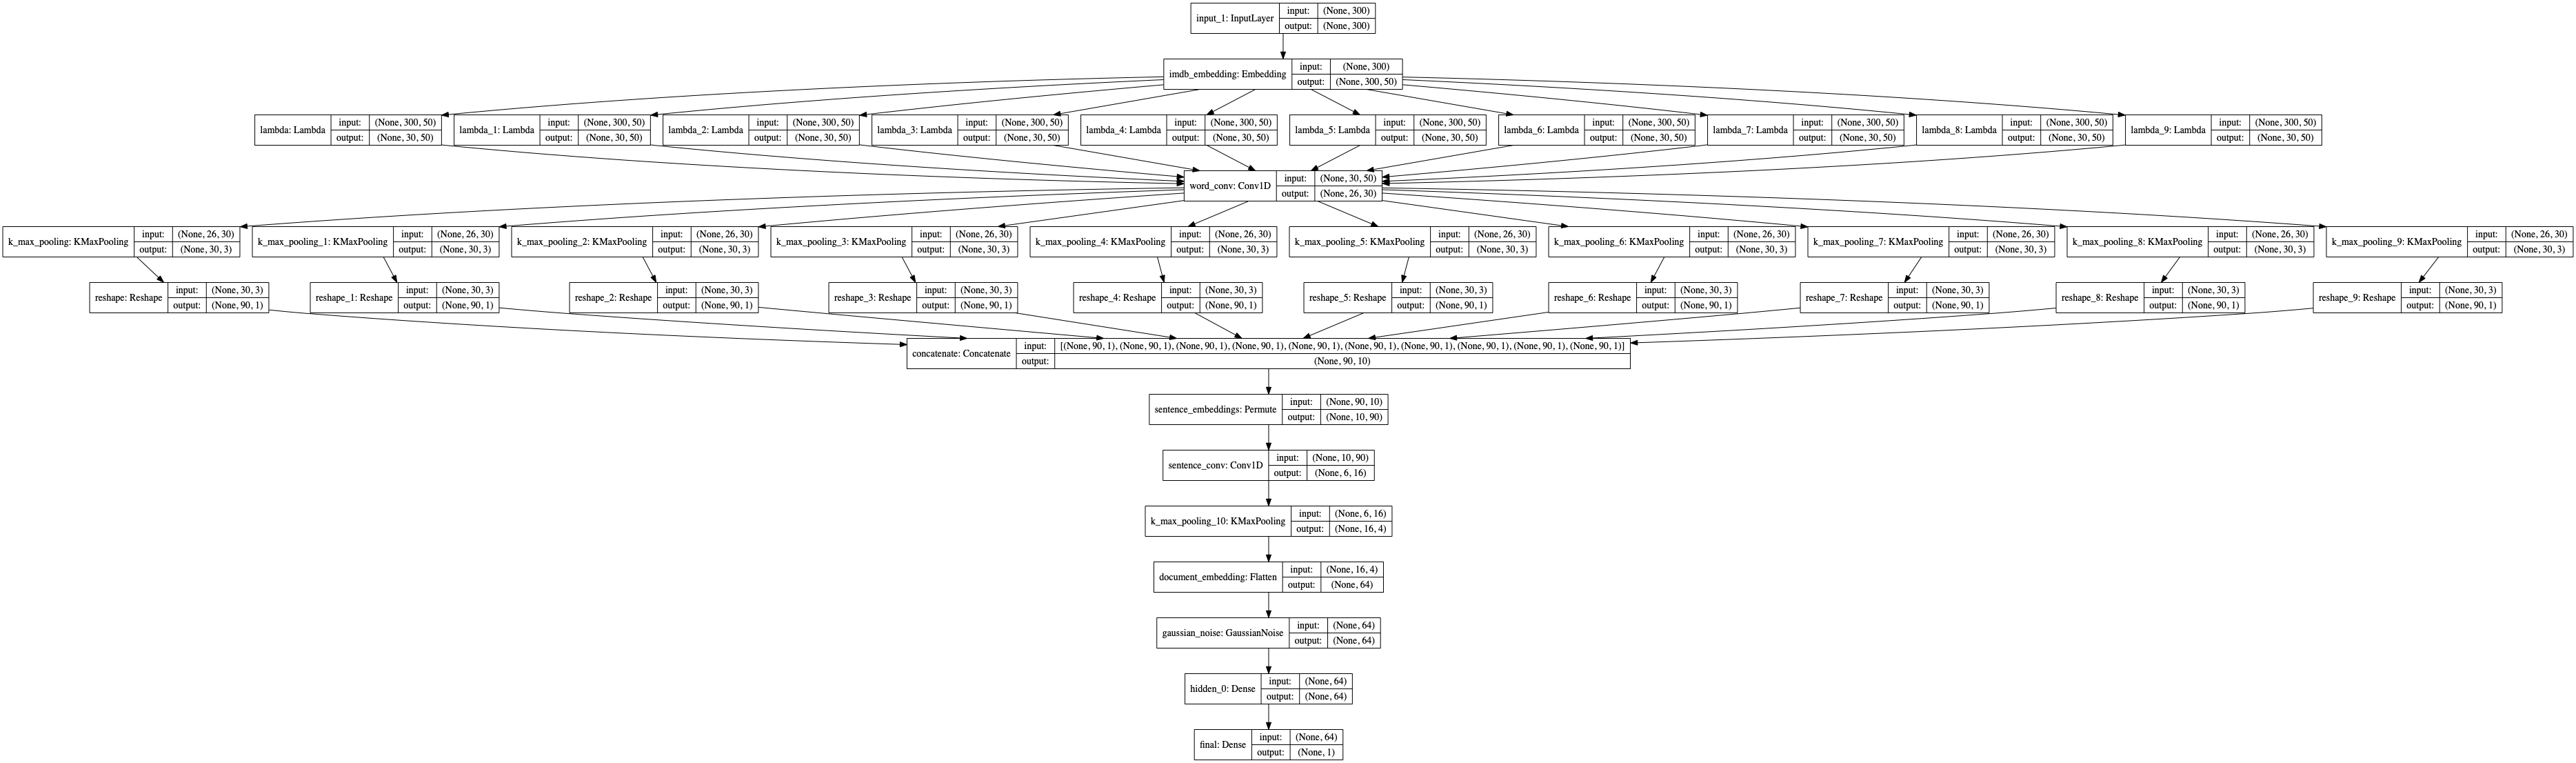